In [1]:
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline


# Import PV Cell data

The PV data was obtained from the clean energy regulator

https://cleanenergyregulator.gov.au/markets/reports-and-data/small-scale-installation-postcode-data#postcode-data-files

According to the website, 
"the data represents all systems that have had certificates validly created against them. The data includes new installations, upgrades to existing systems and stand-alone (off-grid) systems. This data is not publicly available via the REC Registry and does not include systems that are pending registration or have been failed." (CER Website)

It is a collation of small generation units per postcode, not major installations.

These files were downloaded in March 2024. The current years dataset is still available on the website but the historical data is currently unavailable. Each file is an excel sheet, holding one years data plus data for the previous year. The data is split per postocde. File sizes run at approximately 2740 records. 

The data provides number of installations and amount of power (KW) installed. The wattage is the data that is collected per postcode per month. Once all data is collected, it is accumulated as per state. The routine add_state compiles the state post codes based on information from https://post-code.net.au/. This adds the figures of each post code to htier respective state.

Each year is accumulated into one data frome, holding State, Year, Month, Wattage. This will be added to the main dataframe.



In [2]:
def add_state(row):
    tester = row['Postcode'] 
    if tester < 800:
        val="ACT"
    elif tester < 1000:
        val = "NT"
    elif tester < 2600:
        val = "NSW"
    elif tester < 2619:
        val = "ACT"
    elif tester < 2900:
        val = "NSW"
    elif tester < 2921:
        val = "ACT"
    elif tester < 3000:
        val = "NSW"
    elif tester < 4000:
        val = "Victoria"
    elif tester < 5000:
        val = "Queensland"
    elif tester < 6000:
        val = "SA"
    elif tester < 6000:
        val = "WA"
    elif tester < 8000:
        val = "WA"
    elif tester < 9000:
        val = "Victoria"
    else: 
        val="Queensland"
    return val

In [3]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [5]:
path = r'..\data\all_raw_files'
all_files = glob.glob(path + "/*all data.xlsx")
dfs =[]
#print(all_files)

for i, f in enumerate(all_files):
    # Some excel files have changes sheet name
    if i < 14 :
        sheet_name= "SGU-Solar"
        header_size = 2
    elif i < 19:
        sheet_name= "SGU - Solar"
        header_size = 2
    else:
        sheet_name= "SGU-Solar"
        header_size = 3
    
    filename = os.path.basename(f)
    #print(filename)
    #print(i)
    df = pd.read_excel(f, header=header_size, usecols="A, AC, AE, AG, AI, AK, AM, AO, AQ, AS, AU,AW,AY")
    df.columns = ['Postcode', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    df["Postcode"] = df["Postcode"].astype("int")
    df['State'] = df.apply(add_state, axis=1)
    
    df = df.groupby('State').sum().reset_index()
    df["Year"] = i + 2003
    df.drop('Postcode', axis=1, inplace=True)
    
    dfs.append(df)
    

df_item = pd.concat(dfs, ignore_index=True)
pv_install = pd.melt(df_item, id_vars=['State','Year'], value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
pv_install.columns = ['State', 'Year', 'Month', 'KW']
pv_install = pv_install[['State', 'Year', 'Month', 'KW']]


In [6]:
pv_install

,State,Year,Month,KW
0,ACT,2003,1,0.000
1,NSW,2003,1,9.450
2,NT,2003,1,0.000
3,Queensland,2003,1,11.290
4,SA,2003,1,36.055
...,...,...,...,...
1675,NT,2022,12,646.995
1676,Queensland,2022,12,47769.052
1677,SA,2022,12,17896.838
1678,Victoria,2022,12,15864.906


,Date_ins,Cumulate
1,2003-01-01,9.450
141,2003-02-01,15.750
281,2003-03-01,29.206
421,2003-04-01,33.396
561,2003-05-01,35.496
...,...,...
1114,2022-08-01,4782568.490
1254,2022-09-01,4853339.442
1394,2022-10-01,4918860.162
1534,2022-11-01,5005273.656


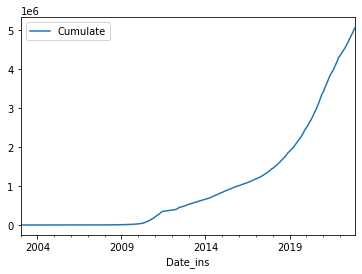

In [37]:
pv_install['Date_ins'] = pd.to_datetime(dict(year=pv_install.Year, month=pv_install.Month, day=1))
# Just get NSW
pv = pv_install[pv_install.State == "NSW"] 
 
pv = pv.sort_values(by=["Date_ins"])
pv["Cumulate"] = pv["KW"].cumsum()
pv = pv[["Date_ins","Cumulate"]]

pv.plot(x= "Date_ins", y="Cumulate")
pv

# Australian population

The population data was found on the ABS website. The data sheet is split per state and per gender. 
https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/sep-2023/310104.xlsx is the link

The file name was changed to State Populations for the purpose of this project.

The datasheet 'Data1' contains population data per state from June 1981 to September 2023. The data is quarterly, so missing monthly data will be extrapolated from the data. The first fields are split by staet/gender but fields T to AA hold population per state data. This will be used in this project. 

The information is in a grid with each state in its own column. This is changed below to hold information by State, Year, Month.

This will allow the data to be merged with the master data, based on State/Year/Month.

The graph below shows a constant increase in the populations of all states over the last 40 years. There is a flattening of the graph in 2020, 2021 which correlates with the population stagnation during Covid.



In [39]:
filename = r'..\data\all_raw_files\State populations.xlsx'
df = pd.read_excel(filename, header=10, sheet_name='Data1', usecols="A, T:AA")
df.columns= ['Date', 'NSW', 'Victoria', 'Queensland', 'SA', 'WA', 'Tasmania', 'NT','ACT']
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.drop('Date', axis=1, inplace=True)

population = pd.melt(df, id_vars=['Year','Month'], value_vars=['NSW', 'Victoria', 'Queensland', 'SA', 'WA', 'Tasmania', 'NT','ACT'])
population.columns = ['Year', 'Month', 'State', 'Population']
population = population[population.State == "NSW"]

In [40]:
population

,Year,Month,State,Population
0,1981,9,NSW,5249455
1,1981,12,NSW,5266894
2,1982,3,NSW,5286119
3,1982,6,NSW,5303580
4,1982,9,NSW,5315846
...,...,...,...,...
163,2022,6,NSW,8166704
164,2022,9,NSW,8208445
165,2022,12,NSW,8246078
166,2023,3,NSW,8298017


State
NSW    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Population, dtype: object

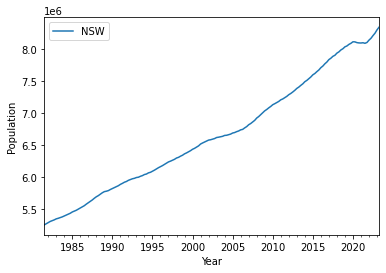

In [41]:
population['Date'] = pd.to_datetime(dict(year=population.Year, month=population.Month, day=1))

pop = population[['State', 'Date', 'Population']]
pop = pop[pop.State == "NSW"]
pop.set_index("Date", inplace=True)
pop.groupby("State")["Population"].plot(legend=True, xlabel="Year", ylabel="Population")

